### Imports

In [1517]:
import struct

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone

from matplotlib import mlab
from scipy.fft import fft, ifft, fftshift, ifftshift, ifft2, fft2
from scipy.spatial.transform import Rotation
from scipy.signal import resample
from scipy.interpolate import interp1d
from scipy.optimize import root, fsolve

from decoding import get_header_dict, packet_generator_from_file, packet_generator, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation
from structs import SUB_COMM_KEY_POS, SUB_COMM_KEY_VAL, WORD_SIZE, F_REF

### Constants

In [1518]:
from scipy.constants import pi, c

s1_center_freq = 5.405000454334350e+09
s1_wavelength = c / s1_center_freq

earth_sidereal = [0, 0, 0.00007292115833]  # rad/s
wgs84_major_a = 6_378_137.0
wgs84_minor_b = 6_356_752.3142
wgs84_eccentricity = 0.0067395

### Plotting

In [50]:
def norm(image):
    return np.abs(image) / np.max(np.abs(image))

def plot_signals(signals, title="", xlabel="", ylabel="", aspect="auto", do_norm=True, do_pop_out=False):

    if do_pop_out:
        %matplotlib qt
    else:
        %matplotlib inline

    # signals = norm(signals)
    signals = np.abs(signals)
    mean = np.mean(signals)
    std = np.std(signals)
    vmin = mean - std
    vmax = mean + 4 * std
    
    fig = plt.figure()
    fig.set_size_inches(12, 3)
    plt.imshow(signals, cmap='jet', aspect=aspect, origin="lower", vmin=vmin, vmax=vmax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def plot_signal_components(signal, scale=(None, None), fft_size=128, sample_rate=3*1e+8, title="", size=(6, 12)):
    start_time = 0
    end_time = start_time + signal.shape[0]
    t = np.linspace(0, end_time, signal.shape[0])
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(size[1], size[0]))
    ax1.plot(t, signal.imag, linewidth=0.75, label='Imaginary Part', color="red")
    ax1.plot(t, signal.real, linewidth=0.75, label='Real Part', color="darkblue")
    ax1.set_title(title)
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    ax1.set_xlim([t[0], t[-1]])
    ax2.plot(t, np.unwrap(np.angle(signal)), linewidth=0.75, color="red")
    ax2.set_xlabel("Time (us)")
    ax2.set_ylabel("Phase")
    ax2.grid(True)
    ax2.set_xlim([t[0], t[-1]])
    if scale is not None:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='seismic', vmin=scale[0], vmax=scale[1], window=mlab.window_hanning, aspect='equal')
    else:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='seismic', aspect='equal')
    ax3.set_xlabel("Time (us)")
    ax3.set_ylabel("Frequency")
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

def save_image(img_data, filename):
    img = np.abs(img_data) / np.max(np.abs(img_data))
    from PIL import Image
    im = Image.fromarray(img)
    im.save(filename)

### Decoding

In [12]:
def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(data)
    swath_packets = []
    packet_index = 0
    while (data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append((packet, packet_index))
            packet_index += 1
        except ValueError as ve:
            break
    return swath_packets

def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet, packet_index in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append((packet, packet_index))
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

def get_all_data_packets_from_file(filename):
    packets = []
    indexes = []
    index = 0
    with open(filename, 'rb') as data:
        PacketGenerator = packet_generator(data)
        while (data):
            try:
                packet = next(PacketGenerator)
                packets.append(packet)
                indexes.append(index)
                index += 1
            except ValueError as ve:
                break
    return packets, indexes

### State Vectors

In [986]:
def mjd2000_time_to_datetime(gps_time_seconds):
    mjd2000_epoch = datetime(2000, 1, 1, tzinfo=timezone(timedelta(0)))
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)

def gps_time_to_datetime(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)
    return current_time
    
def gps_time_to_seconds_since_midnight(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    whole_seconds = int(gps_time_seconds)
    fractional_seconds = gps_time_seconds - whole_seconds
    current_time = gps_epoch + timedelta(seconds=whole_seconds)
    seconds_since_midnight = (
        current_time.hour * 3600 +
        current_time.minute * 60 +
        current_time.second +
        fractional_seconds
    )
    return seconds_since_midnight

def data_word_time_stamp_to_seconds(time_stamp):
    time_stamp = time_stamp[8:64]
    num = 0
    for i in range(0, 32):
        num += int(time_stamp[i]) * (2 ** (32-i-1))
    for i in range(33, 56):
        num += int(time_stamp[i]) * (2 ** (-i))
    return num

def get_gps_time_from_packet(packet):
    header = packet.get_secondary_header()
    seconds = header['coarse_time']
    sub_seconds = 1 / header['fine_time']
    return gps_time_to_seconds_since_midnight(seconds + sub_seconds)

def annotation_time_to_datetime(days, milliseconds, microseconds):
    mj2000_epoch = datetime(2000, 1, 1, tzinfo=timezone(timedelta(0)))
    current_time = mj2000_epoch + timedelta(days=days, seconds=0, milliseconds=milliseconds, microseconds=microseconds)
    return current_time

def get_azimuth_time_from_record(record):
    days = record['days_ul']
    milliseconds = record['milliseconds_ul']
    microseconds = record['microseconds_ul']
    return annotation_time_to_datetime(days, milliseconds, microseconds)

def get_records(filename):
    filename_prefix = filename.split('.')[0]

    annotation_filename = filename_prefix + '_annot.dat'
    index_filename = filename_prefix + '_index.dat'
    
    with open(annotation_filename, 'rb') as annot_data:
        annotation_records = annotation_decoder(annot_data)
    with open(index_filename, 'rb') as index_data:
        index_records = index_decoder(index_data)
    return annotation_records, index_records

def to_float32(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('f', struct.pack('I', int_representation))[0]
    return float_value

def to_float64(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('d', struct.pack('Q', int_representation))[0]
    return float_value

def build_data_word_dict(packets, indexes, times):
    data_word_dicts = []
    sub_comm_dict = SUB_COMM_KEY_VAL.copy()
    initial_data_word_index = 0
    sc_data_word_index = 0
    for i in range(len(packets)):
        packet = packets[i]
        secondary_header = packet.get_secondary_header()
        sc_data_word_index = secondary_header['sc_data_word_index']
        if i == 0:
            initial_data_word_index = sc_data_word_index
        else:
            if sc_data_word_index == initial_data_word_index:
                sub_comm_dict['azimuth_time'] = times[indexes[i]]
                data_word_dicts.append(sub_comm_dict)
                sub_comm_dict = SUB_COMM_KEY_VAL.copy()
        data_word =  secondary_header['sc_data_word']
        key, pos = SUB_COMM_KEY_POS[sc_data_word_index]
        pos = pos * WORD_SIZE
        sub_comm_dict[key] = sub_comm_dict[key][0:pos] + data_word + sub_comm_dict[key][pos+WORD_SIZE:]
    if sc_data_word_index != initial_data_word_index:
        data_word_dicts.append(sub_comm_dict)
    for i in range(len(data_word_dicts)):
        data_word_dicts[i]['x_axis_position'] = to_float64(data_word_dicts[i]['x_axis_position'])
        data_word_dicts[i]['y_axis_position'] = to_float64(data_word_dicts[i]['y_axis_position'])
        data_word_dicts[i]['z_axis_position'] = to_float64(data_word_dicts[i]['z_axis_position'])
        data_word_dicts[i]['x_axis_velocity'] = to_float32(data_word_dicts[i]['x_axis_velocity'])
        data_word_dicts[i]['y_axis_velocity'] = to_float32(data_word_dicts[i]['y_axis_velocity'])
        data_word_dicts[i]['z_axis_velocity'] = to_float32(data_word_dicts[i]['z_axis_velocity'])
        data_word_dicts[i]['q0_quaternion']   = to_float32(data_word_dicts[i]['q0_quaternion'])
        data_word_dicts[i]['q1_quaternion']   = to_float32(data_word_dicts[i]['q1_quaternion'])
        data_word_dicts[i]['q2_quaternion']   = to_float32(data_word_dicts[i]['q2_quaternion'])
        data_word_dicts[i]['q3_quaternion']   = to_float32(data_word_dicts[i]['q3_quaternion'])
        data_word_dicts[i]['omega_x']         = to_float32(data_word_dicts[i]['omega_x'])
        data_word_dicts[i]['omega_y']         = to_float32(data_word_dicts[i]['omega_y'])
        data_word_dicts[i]['omega_z']         = to_float32(data_word_dicts[i]['omega_z'])
    return data_word_dicts

def get_times_from_subcomm_dicts(subcomm_dicts):
    times = []
    for subcomm_dict in subcomm_dicts[:-1]:
        gps_time = data_word_time_stamp_to_seconds(subcomm_dict["data_time_stamp"])
        data_time = gps_time_to_datetime(gps_time)
        times.append(data_time)
    return np.asarray(times)

def get_velocities_from_subcomm_dicts(subcomm_dicts):
    velocities = []
    for subcomm_dict in subcomm_dicts[:-1]:
        vx = subcomm_dict["x_axis_velocity"]
        vy = subcomm_dict["y_axis_velocity"]
        vz = subcomm_dict["z_axis_velocity"]
        velocities.append([vx, vy, vz])
    return np.asarray(velocities, dtype=np.float64)

def get_positions_from_subcomm_dicts(subcomm_dicts):
    positions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        px = subcomm_dict["x_axis_position"]
        py = subcomm_dict["y_axis_position"]
        pz = subcomm_dict["z_axis_position"]
        positions.append([px, py, pz])
    return np.asarray(positions, dtype=np.float64)

def quaternion_to_rotation_matrix(q):
    """https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf"""
    q0, q1, q2, q3 = q
    e00 = q0**2 - q1**2 - q2**2 + q3**2
    e01 = 2 * (q0 * q1 + q2 * q3)
    e02 = 2 * (q0 * q2 - q1 * q3)
    e10 = 2 * (q0 * q1 - q2 * q3)
    e11 = -q0**2 + q1**2 - q2**2 + q3**2
    e12 = 2 * (q1 * q2 + q0 * q3)
    e20 = 2 * (q0 * q2 + q1 * q3)
    e21 = 2 * (q1 * q2 - q0 * q3)
    e22 = -q0**2 - q1**2 + q2**2 + q3**2
    R = np.array([
        [e00, e01, e02],
        [e10, e11, e12],
        [e20, e21, e22]
    ])
    return R

def get_quaternions_from_subcomm_dicts(subcomm_dicts):
    quaternions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        q0 = subcomm_dict['q0_quaternion']
        q1 = subcomm_dict['q1_quaternion']
        q2 = subcomm_dict['q2_quaternion']
        q3 = subcomm_dict['q3_quaternion']
        m_eo_cfi = quaternion_to_rotation_matrix([q1, q2, q3, q0])
        m = np.asarray([-m_eo_cfi[1], -m_eo_cfi[0], -m_eo_cfi[2]])
        rotation_eo_cfi_sat_att = Rotation.from_matrix(m)
        q0, q1, q2, q3 = rotation_eo_cfi_sat_att.as_quat()
        quaternions.append([-q0, -q1, -q2, q3])
    return np.asarray(quaternions, dtype=np.float64)

def get_angular_rates_from_subcomm_dicts(subcomm_dicts):
    angular_rates = []
    for subcomm_dict in subcomm_dicts[:-1]:
        omega_x = subcomm_dict['omega_x']
        omega_y = subcomm_dict['omega_y']
        omega_z = subcomm_dict['omega_z']
        angular_rates.append([omega_x, omega_y, omega_z])
    return np.asarray(angular_rates, dtype=np.float64)

def quaternion_to_rotation_matrix_for_euler(q):
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2 * (q2**2 + q3**2), 2 * (q1*q2 - q3*q0), 2 * (q1*q3 + q2*q0)],
        [2 * (q1*q2 + q3*q0), 1 - 2 * (q1**2 + q3**2), 2 * (q2*q3 - q1*q0)],
        [2 * (q1*q3 - q2*q0), 2 * (q2*q3 + q1*q0), 1 - 2 * (q1**2 + q2**2)]
    ])
    return R

def get_euler_angles(quaternions):
    """ Thanks to this
    https://www.researchgate.net/post/Can-someone-explain-the-Sentinel-1-orientation-quanternion-vs-pitch-roll-yaw-numbers-to-me
    and this
    https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf
    """
    euler_angles = []
    for quaternion in quaternions:
        q0, q1, q2, q3 = quaternion
        rotation = Rotation.from_quat(quaternion).as_euler('YXZ', degrees=True)
        pitch = -rotation[0]
        roll = -rotation[1]
        yaw = rotation[2]
        euler = (np.asarray([roll, pitch, yaw]) * 2 * pi / 360.0)
        euler_angles.append(euler)
    return np.asarray(euler_angles)

def get_state_vectors_from_subcomm_dicts(subcomm_dicts):
    times = list(get_times_from_subcomm_dicts(subcomm_dicts))
    unique_times = list(dict.fromkeys(times))
    unique_indexes = [times.index(unique_time) for unique_time in unique_times]
    quaternions = get_quaternions_from_subcomm_dicts(subcomm_dicts)[unique_indexes]
    azimuth_times = [subcomm_dicts[i]["azimuth_time"] for i in unique_indexes]
    start_time = azimuth_times[0]
    return {
        "time": unique_times,
        "azimuth_time": azimuth_times,
        "velocity": get_velocities_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "position": get_positions_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "quaternion": get_quaternions_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "angular_rate": get_angular_rates_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "euler_angle": get_euler_angles(quaternions)  
    }

def datetime_to_seconds(datetimes):
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    seconds = np.array([(dt - gps_epoch).total_seconds() for dt in datetimes])
    return seconds

def interpolate_state_vector(state_vector, state_vector_times):
    time_seconds = datetime_to_seconds(state_vector_times)
    interp_functions = []
    for i in range(state_vector.shape[1]):
        interp_functions.append(interp1d(time_seconds, state_vector[:, i], kind='linear', fill_value="extrapolate"))
    return tuple(interp_functions)

def get_state_vector_functions(state_vectors):
    x_interp, y_interp, z_interp = interpolate_state_vector(state_vectors["position"], state_vectors["time"])
    vx_interp, vy_interp, vz_interp = interpolate_state_vector(state_vectors["velocity"], state_vectors["time"])
    q0_interp, q1_interp, q2_interp, q3_interp = interpolate_state_vector(state_vectors["quaternion"], state_vectors["time"])
    roll_interp, pitch_interp, yaw_interp = interpolate_state_vector(state_vectors["euler_angle"], state_vectors["time"])
    wsx_interp, wsy_interp, wsz_interp = interpolate_state_vector(state_vectors["angular_rate"], state_vectors["time"])
    
    get_position = lambda t: np.asarray(list((x_interp(t), y_interp(t), z_interp(t))))
    get_velocity = lambda t: np.asarray(list((vx_interp(t), vy_interp(t), vz_interp(t))))
    get_quaternions = lambda t: np.asarray(list((q0_interp(t), q1_interp(t), q2_interp(t), q3_interp(t))))
    get_attitude = lambda t: np.asarray(list((roll_interp(t), pitch_interp(t), yaw_interp(t))))
    get_angular_rate = lambda t: np.asarray(list((wsx_interp(t), wsy_interp(t), wsz_interp(t))))

    return get_position, get_velocity, get_quaternions, get_attitude, get_angular_rate

### Range Compression

In [14]:
range_decimation_list = [
    112.6041667, 100.0925926, 0.000000000, 83.41049387,
    66.72839509, 56.30208336, 50.04629632, 25.02314816,
    64.34523813, 46.91840280, 17.32371796, 54.59595962
]

def get_replica_chirp(packet, num_range_samples):
    secondary_header = packet.get_secondary_header()
    range_decimation = secondary_header['range_decimation']
    txpsf = secondary_header['tx_pulse_start_frequency']
    txprr = secondary_header['tx_ramp_rate']
    txpl  = secondary_header['pulse_length']
    phi_1 = txpsf
    phi_2 = txprr / 2
    fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
    t = np.linspace(0.0, txpl, fs)
    chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
    index_start = np.ceil((num_range_samples-fs)/2)-1
    index_end = fs+index_start
    ref = np.zeros((num_range_samples,), dtype=complex)
    ref[int(index_start):int(index_end)] = chirp
    return ref

def pulse_compression(chirp, replica):
    num_range_samples = chirp.shape[0]
    num_rep_samples = replica.shape[0]
    pulse_compressed = chirp * np.conj(fft(replica))
    return pulse_compressed

def range_compress_burst(signals, replica_chirp, do_2d=False):
    num_packets = signals.shape[0]

    if do_2d:
        signals = fft(signals)
        signals = fftshift(fft(signals, axis=0), axes=0)
    else:
        signals = fft(signals)

    range_compressed = []
    for i in range(num_packets):
        range_compressed.append(pulse_compression(signals[i], replica_chirp))
    return np.asarray(range_compressed)

### Parameters and Metadata| for Azimuth Compression

In [1649]:
def azimuth_beam_address_to_angle(azimuth_beam_address):
    first_address = -0.018
    last_address = 0.018
    num_addresses = 1024
    azimuth_angles = np.linspace(first_address, last_address, num_addresses)
    return azimuth_angles[azimuth_beam_address]

def get_azimuth_steering_angles(packets):
    azimuth_angles = []
    for packet in packets:
        header = packet.get_secondary_header()
        azimuth_beam_address = header["azimuth_beam_address"]
        azimuth_angles.append(azimuth_beam_address_to_angle(azimuth_beam_address))
    return np.asarray(azimuth_angles)

def get_azimuth_steering_rates(azimuth_angles, pri):
    differences = []
    for i in range(len(azimuth_angles)):
        if (i != 0):
            difference = azimuth_angles[i] - azimuth_angles[i-1]
            differences.append(difference)
    steering_rate_rad_per_second = np.asarray(differences) / pri
    return steering_rate_rad_per_second

def get_azimuth_steering_rate(azimuth_angles, pri):
    num_angles = azimuth_angles.shape[0]
    return (azimuth_angles[-1] - azimuth_angles[0]) / (pri * num_angles)

def calculate_doppler_centroid_rates(velocities, steering_rates):
    return np.abs((-2 * velocities * steering_rates) / s1_wavelength)

def calculate_doppler_centroid_rate(velocity, steering_rate):
    return (-2 * velocity * steering_rate) / s1_wavelength

def get_slant_range(header):
    # Same for all packets in a burst
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = packet_header["swst"] * 1e-6
    pri = packet_header["pri"] * 1e-6
    rank = packet_header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    slant_range = delay * c / 2
    return slant_range

def get_slant_ranges(header):
    # Same for all packets in a burst
    pulse_length = header["pulse_length"] * 1e-6
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = header["swst"] * 1e-6
    pri = header["pri"] * 1e-6
    rank = header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    slant_range_start = delay * c / 2
    slant_range_end = (delay + pulse_length) * c / 2
    return slant_range_start, slant_range_end

### Azimuth Compression

In [1535]:
def get_effective_velocities(header, positions, velocities, slant_ranges):
    heights = np.asarray([np.linalg.norm(position) for position in positions])

    lat = np.arctan(np.divide(positions[:, 2], positions[:, 0]))
    local_earth_rad = np.sqrt(
        np.divide(
            (np.square(wgs84_major_a**2 * np.cos(lat)) + np.square(wgs84_minor_b**2 * np.sin(lat))),
            (np.square(wgs84_major_a * np.cos(lat)) + np.square(wgs84_minor_b * np.sin(lat)))
        )
    )
    
    v = np.asarray([np.linalg.norm(velocity) for velocity in velocities])
    cos_beta = (np.divide(np.square(local_earth_rad) + np.square(heights) - np.square(slant_ranges[:, np.newaxis]) , 2 * local_earth_rad * heights))
    ground_velocities = local_earth_rad * v * cos_beta / heights
    
    return np.sqrt(v * ground_velocities)


def get_range_migration_factor(header, effective_velocities):
    pulse_length = header['pulse_length'] * 1e-6
    
    pri = header['pri'] * 1e-6
    prf = 1 / pri
    
    az_freq_vals = np.linspace(-prf/2, prf/2, num_az)
    
    return np.sqrt(
        1 - np.divide(
            s1_wavelength**2 * np.square(az_freq_vals),
            4 * np.square(effective_velocities)
        )
    ).T



def range_cell_migration_correction(image, rcmc_factor, header):
    _, num_rng = image.shape

    range_sample_freq = range_decimation_list[header['range_decimation']]
    range_freq_vals = np.linspace(-range_sample_freq/2, range_sample_freq/2, num=num_rng)

    rcmc_shift = slant_ranges[0] * (np.divide(1, rcmc_factor) - 1)
    rcmc_filter = np.exp(4j * np.pi * range_freq_vals * rcmc_shift / c)

    return np.multiply(image, rcmc_filter)


def get_range_migration_factor_w_az_freqs(header, effective_velocities, az_freqs):
    pulse_length = header['pulse_length'] * 1e-6

    pri = header['pri'] * 1e-6
    prf = 1 / pri

    return np.sqrt(
        1 - np.divide(
            c**2 * np.square(az_freqs),
            4 * np.square(effective_velocities) * s1_center_freq**2
        )
    ).T


def azimuth_compression(image, slant_ranges, rcmc_factor):
    num_az, num_rng = image.shape
    image = ifftshift(ifft(image, axis=1), 1)
    az_filter = np.exp(4j * np.pi * slant_ranges * rcmc_factor / s1_wavelength)
    window = np.hamming(num_az)
    return ifft(np.multiply(np.multiply(window[:, np.newaxis], image), az_filter), num_az, axis=0)

### Load Data

In [1455]:
raw_filename = '/Users/asplayer/repos/sentinel1_decode/data/points/point.dat'
npy_filename = '/Users/asplayer/data/L0_npz/points_iw2_10.npy'

data = open(raw_filename, 'rb')
signals = np.load(npy_filename)
num_az, num_rng = signals.shape

swath_packets = get_packets_in_swath(data, 11)
burst_packet_pairs = get_packets_in_burst(swath_packets, 10)
burst_packets = [packet for packet, _ in burst_packet_pairs]
packet_indecies = [index for _, index in burst_packet_pairs]
header = burst_packets[0].get_secondary_header()

first_index = packet_indecies[0]
last_index = packet_indecies[-1]

### Load State Vectors

In [929]:
packets, indexes = get_all_data_packets_from_file(raw_filename)
annotation_records, index_records = get_records(raw_filename)

azimuth_times = [get_azimuth_time_from_record(record) for record in annotation_records]
subcomm_dicts = build_data_word_dict(packets, indexes, azimuth_times)
state_vectors = get_state_vectors_from_subcomm_dicts(subcomm_dicts)
get_position, get_velocity, get_quaternions, get_attitude, get_angular_rate = get_state_vector_functions(state_vectors)

az_times = datetime_to_seconds(azimuth_times[first_index:last_index+1])

times = [get_gps_time_from_packet(packet) for packet in burst_packets]
velocities = np.asarray([get_velocity(time) for time in az_times])
positions = np.asarray([get_position(time) for time in az_times])
quaternions = np.asarray([get_quaternions(time) for time in az_times])
attitudes = np.asarray([get_attitude(time) for time in az_times])

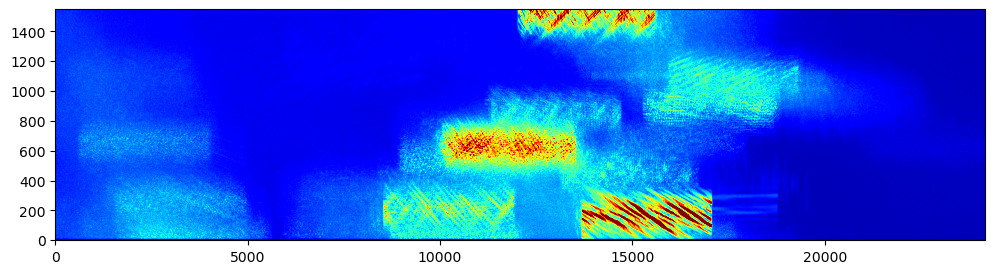

In [21]:
plot_signals(signals)

### Image Formation

In [1487]:
replica_chirp = get_replica_chirp(burst_packets[0], num_rng)
range_compressed = ifft(range_compress_burst(signals, replica_chirp, do_2d=False), axis=1)
range_doppler = fftshift(fft(range_compressed, axis=0), 0)

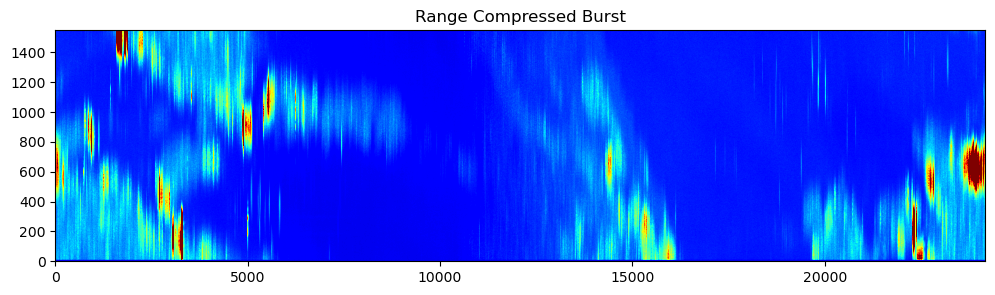

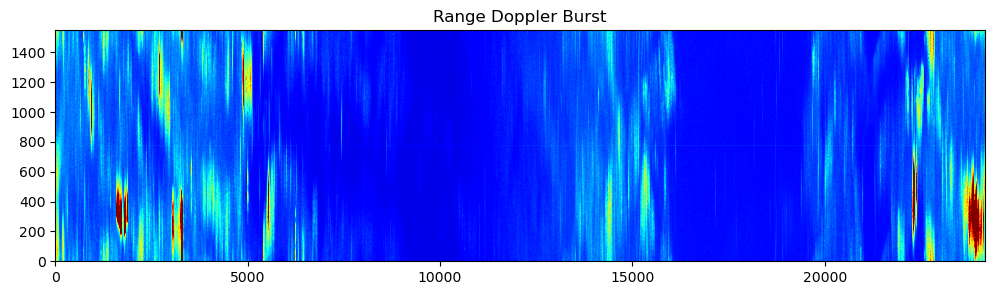

In [1488]:
plot_signals(range_compressed, title='Range Compressed Burst')
plot_signals(range_doppler, title='Range Doppler Burst')

In [1489]:
slant_range_start, slant_range_end = get_slant_ranges(header)
slant_ranges = np.linspace(slant_range_start, slant_range_end, num_rng)
effective_velocities = get_effective_velocities(header, positions, velocities, slant_ranges)

In [1519]:
prf = 1 / (header['pri'] * 1e-6)
az_freqs = np.linspace(f_dc-prf/2, f_dc+prf/2, num_az).T
rcmc_factor_w_az_freqs = get_range_migration_factor_w_az_freqs(header, effective_velocities, az_freqs)
range_migrated = fft(range_cell_migration_correction(range_doppler, rcmc_factor_w_az_freqs, header))
azimuth_compressed = azimuth_compression(range_migrated, slant_ranges, rcmc_factor_w_az_freqs)

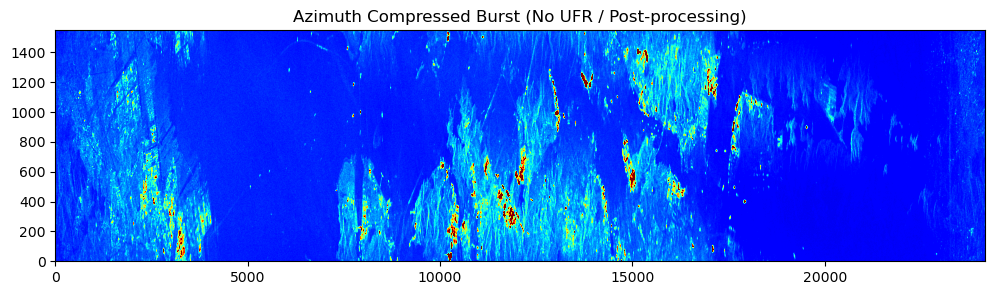

In [1520]:
plot_signals(azimuth_compressed, title='Azimuth Compressed Burst (No UFR / Post-processing)')

In [1687]:
def get_accc(signals, prf, lag):
    xcor_cmp = (signals[lag:] * signals[:-lag].conj()).mean()
    acor_mag = np.sqrt((abs(signals[lag:])**2).mean()) * np.sqrt((abs(signals[:-lag])**2).mean())
    corr_coef = np.abs(xcor_cmp) / acor_mag if acor_mag > 0 else 0
    return prf / (2.0 * pi * lag) * np.angle(xcor_cmp), corr_coef

def get_accc_with_range_blocks(signals, prf, lag, range_block_size):
    num_az, num_rng = signals.shape
    num_range_blocks = num_rng // range_block_size
    amb_dcs = []
    corr_coefs = []
    for i in range(num_range_blocks):
        start_index = i * range_block_size
        end_index = start_index + range_block_size
        range_block = signals[:, start_index:end_index]
        amb_dc, corr_coef = get_accc(range_block, prf, lag)
        amb_dcs.append(amb_dc)
        corr_coefs.append(corr_coef)
    return np.asarray(amb_dcs), np.asarray(corr_coefs)

def unwrap_doppler(doppler, prf):
    # From ISCE2
    frq2phs = 2 * np.pi / prf
    phs2frq = 1. / frq2phs
    return phs2frq * np.unwrap(frq2phs * doppler)

def get_doppler_coefs(signals, prf, lag=1, range_block_size=30):
    """Signals param can be either range compressed data or the raw signals"""
    range_block_size = 27
    amb_dcs, corr_ceofs = get_accc_with_range_blocks(signals, prf, 1, range_block_size)
    unwrapped_doppler = unwrap_doppler(amb_dcs, prf)
    range_bins = np.arange(0, num_rng, range_block_size)[0:-1]
    return np.polyfit(range_bins, unwrapped_doppler, 2)

def get_deramped_burst(range_compressed_data, burst_packets, steering_angles, velocities):
    header = burst_packets[0].get_secondary_header()
    pri = header['pri'] * 1e-6
    prf = 1 / pri
    v_norm = np.asarray([np.linalg.norm(velocity) for velocity in velocities])
    steering_angles = get_azimuth_steering_angles(burst_packets)
    steering_rate = get_azimuth_steering_rate(steering_angles, pri)
    dc_rate = calculate_doppler_centroid_rate(v_norm, steering_rate)
    az_times = np.arange(0, num_az, 1) * pri
    burst_length = az_times[-1]
    deramping_signal = np.exp(1j * pi * dc_rate * (az_times - (burst_length/2))**2)
    deramped = np.multiply(deramping_signal[:, np.newaxis], ifft2(range_compressed_data))
    return deramped

def get_doppler(coefs, az_line):
    return np.polyval(coefs, az_line)

def get_dopplers(coefs, num_dops):
    return np.polyval(coefs, np.arange(0, num_dops, 1))

def get_K_src(rcmc_data, D, effective_velocities, az_freqs, slant_ranges):
    K_src = np.divide(
        2 * (effective_velocities ** 2) * (s1_center_freq ** 3) * (D ** 2), 
        c * (slant_ranges * az_freqs[:, np.newaxis] ** 2).T 
    ).T
    return fft(ifft(rcmc_data, axis=1) * np.exp(-1j * pi * rcmc_data ** 2 / K_src), axis=1)

def get_ka(Vr, D, R_0, wavelength):
    # Azimuth FM Rate
    return (2 * (Vr.T**2) * (D**3)) / (wavelength * R_0)

def get_ks(burst_packets, velocities):
    # Doppler Centroid Rate
    v_norm = np.asarray([np.linalg.norm(velocity) for velocity in velocities])
    pri = burst_packets[0].get_secondary_header()['pri'] * 1e-6
    steering_angles = get_azimuth_steering_angles(burst_packets)
    steering_rate = get_azimuth_steering_rates(steering_angles, pri)
    return calculate_doppler_centroid_rates(v_norm[:-1], steering_rate)

def azimuth_freq_unfold_line(range_doppler_line, line_number, shape, doppler_coefs, ks, ka, prf):
    num_az, num_rng = shape
    f_dc = get_doppler(doppler_coefs, line_number)
    mid_swath = num_rng  // 2
    f_ref = np.abs(get_doppler(doppler_coefs, mid_swath))

    B_s = prf / 2
    N_s_neg = np.floor(f_ref - (B_s/2) / prf)
    N_s_pos = np.ceil(f_ref + (B_s/2) / prf)
    N_s = int(N_s_pos - N_s_neg)

    num_upsample = int(num_az*N_s)
    freqs_deramp = f_dc + np.linspace(-B_s/2, B_s/2, num_upsample)
    deramp_filt = np.exp(1j * pi * (1 / ks) * (freqs_deramp-f_dc)**2)
    freqs_reramp = f_dc + np.linspace(-B_s/2, B_s/2, num_upsample)
    reramp_filt = np.exp(-1j * pi * (1 / ks) * (freqs_reramp-f_dc)**2)

    new_sig = np.zeros((num_upsample), dtype=complex)
    for i in range(N_s):
        new_sig[i*num_az: i*num_az+num_az] = ifft(range_doppler_line)
    new_sig = fftshift(fft(new_sig))

    deramped = new_sig * deramp_filt
    f = fft(deramped)
    f[num_az:] = 0
    f = ifft(f)
    reramped = f * reramp_filt
    return new_sig, deramped, f, resample(reramped, 4*num_az)[::-1]
    
# def azimuth_freq_unfold(range_doppler_data, doppler_coefs, ks, ka, prf):
#     num_az, num_rng = range_doppler_data.shape
#     reramped_arr = []
#     for az_line in range(num_rng):
#         f_dc = get_doppler(doppler_coefs, az_line)
#         mid_swath = num_rng  // 2
#         f_ref = np.abs(get_doppler(doppler_coefs, mid_swath))

#         B_s = prf / 2
#         N_s_neg = np.floor(f_ref - (B_s/2) / prf)
#         N_s_pos = np.ceil(f_ref + (B_s/2) / prf)
#         N_s = int(N_s_pos - N_s_neg)

#         num_upsample = int(num_az*N_s)
#         freqs_deramp = f_dc + np.linspace(-B_s/2, B_s/2, num_upsample)
#         deramp_filt = np.exp(1j * pi * (1 / ks) * (freqs_deramp-f_dc)**2)
#         freqs_reramp = f_dc + np.linspace(-B_s/2, B_s/2, num_upsample)
#         reramp_filt = np.exp(-1j * pi * (1 / ks) * (freqs_reramp-f_dc)**2)

#         sig = range_doppler_data[:, az_line]
#         new_sig = np.zeros((num_upsample), dtype=complex)
#         for i in range(N_s):
#             new_sig[i*num_az: i*num_az+num_az] = fft(sig)
#         new_sig = ifftshift(ifft(new_sig))

#         deramped = new_sig * deramp_filt
#         f = fft(deramped)
#         f[num_az:] = 0
#         f = ifft(f)
#         reramped = f * reramp_filt
#         reramped_arr.append(resample(reramped, num_az)[::-1])
#     return np.asarray(reramped_arr).T

def azimuth_freq_unfold(range_doppler_data, doppler_coefs, ks, ka, prf):
    num_az = range_doppler_data.shape[0]
    reramped_arr = []

    B_max = np.abs(ks * 1 + prf)
    B_az = np.abs((-ka / (np.abs(ks) - ka)) * prf).max()
    B_s = B_az / 1.06

    mid_swath = num_rng // 2
    f_ref = f_dc[mid_swath]
    N_s_neg = np.floor(f_ref - (B_s/2) / prf)
    N_s_pos = np.ceil(f_ref + (B_s/2) / prf)
    N_s = int(N_s_pos - N_s_neg)

    print(f'Max Bandwidth (B_max): {B_max}')
    print(f'Azimuth Bandwidth (B_az): {B_az}')
    print(f'Sweep Bandwidth (B_s): {B_s}')
    print(f'Number of Spectral Replicas: {N_s}')

    num_upsample = int(num_az*N_s)

    for az_line in range(num_rng):

        freqs_deramp = f_dc[az_line] + np.linspace(-B_s/2, B_s/2, num_upsample)
        deramp_filt = np.exp(1j * pi * (1 / ks) * (freqs_deramp-f_dc[az_line])**2)
    
        freqs_reramp = f_dc[az_line] + np.linspace(-N_s*prf/2, N_s*prf/2, num_upsample)
        reramp_filt = np.exp(-1j * pi * (1 / ks) * (freqs_reramp-f_dc[az_line])**2)
    
        new_sig = np.zeros((num_upsample), dtype=complex)
        for i in range(N_s):
            new_sig[i*num_az: i*num_az+num_az] = range_doppler_data[:, az_line]
        new_sig = new_sig
    
        deramped = new_sig * deramp_filt
        f = fft(deramped)
    
        mid_index = num_upsample // 2
        cutoff = int(np.floor((B_s / B_max) * num_az))
        f[cutoff:] = 0
    
        f = ifft(f)
        reramped = f * reramp_filt
        reramped_arr.append(resample(reramped, num_az)[::-1])
    return np.asarray(reramped_arr).T

In [1548]:
doppler_coefs = get_doppler_coefs(range_compressed, prf, lag=1, range_block_size=30)

In [1650]:
steering_angles = get_azimuth_steering_angles(burst_packets)
steering_rate = get_azimuth_steering_rate(steering_angles, pri)
ks = calculate_doppler_centroid_rate(np.linalg.norm(velocities[0]), steering_rate)
# ka = get_ka(effective_velocities, rcmc_factor_w_az_freqs, slant_ranges, s1_wavelength)

In [1651]:
ks

np.float64(-4700.096529398185)

In [1688]:
ufr_data = azimuth_freq_unfold(range_doppler, doppler_coefs, ks, ka, prf)

Max Bandwidth (B_max): 3248.4694172041955
Azimuth Bandwidth (B_az): 1285.4771667701207
Sweep Bandwidth (B_s): 1212.7143082736986
Number of Spectral Replicas: 2


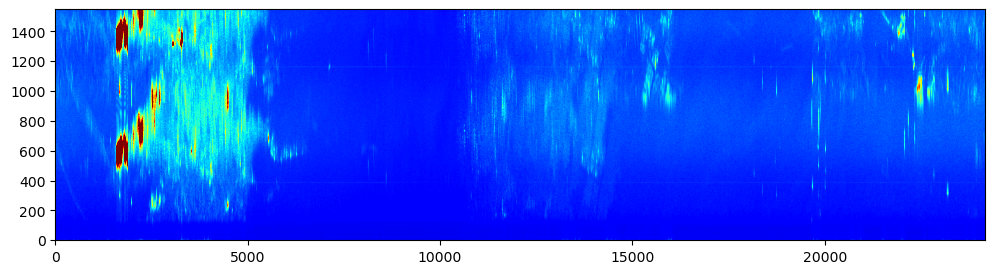

In [1689]:
plot_signals(ufr_data)

In [1692]:
num_az_samples = ufr_data.shape[0]

if num_az_samples != num_az:
    effective_velocities_resamped = np.zeros((num_rng, num_az_samples))
    for i in range(num_rng):
        effective_velocities_resamped[i, :] = resample(effective_velocities[i, :], num_az_samples)
else:
    effective_velocities_resamped = effective_velocities

# f_dc = get_dopplers(doppler_coefs, num_rng)
az_freqs = np.linspace(f_dc-prf, f_dc+prf, num_az_samples).T
rcmc_factor_w_az_freqs = get_range_migration_factor_w_az_freqs(header, effective_velocities_resamped, az_freqs)
range_migrated = fft(range_cell_migration_correction(ufr_data, rcmc_factor_w_az_freqs, header))
azimuth_compressed = azimuth_compression(range_migrated, slant_ranges, rcmc_factor_w_az_freqs)

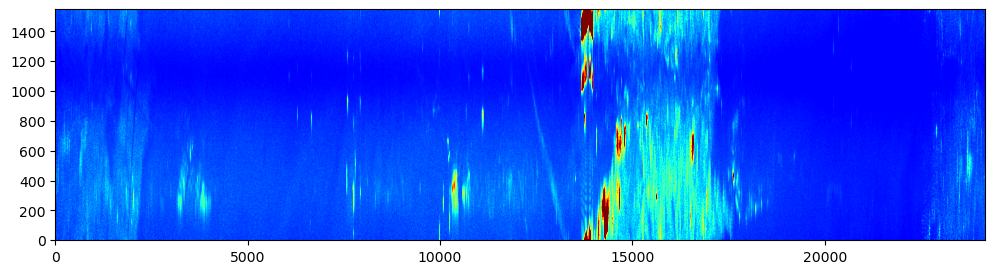

In [1693]:
plot_signals(azimuth_compressed)

In [1553]:
save_image(azimuth_compressed, "az_comp_test_4.tif")

In [1680]:
'''
Notes:

az_time_range: -f_dc/ka - T_b/2 <= n <= -f_dc/ka + T_b/2
az_freq_range: f_dc - prf/2 <= f_dc <= f_dc + prf/2

B_max: ks * T_b + prf
B_az: -ka/(ks-ka) * prf

B_d < B_az AND must guarantee the azimuth resolution
T_d: -B_d/ka
B_s: ks(T_b - T_d) + B_d

Optionally, B_s can be a configurable input param that satifies B_s <= B_max.
'''

def get_B(az_ind, rng_ind, ks, ka, Tb, prf):
    B_max = ks * Tb + prf
    B_az = -prf * ka[:, rng_ind] / (ks - ka[:, rng_ind])
    return B_max, B_az


def interp_rates(dc_rate, time_stamps_az, time_stamps_upsample, kind="cubic"):
    non_zero_points = dc_rate != 0
    non_zero_rates = dc_rate[non_zero_points]
    non_zero_times = time_stamps_az[non_zero_points]

    interp_func = interp1d(non_zero_times, non_zero_rates, kind=kind, fill_value="extrapolate")
    smoothed_rates = interp_func(time_stamps_upsample)

    return smoothed_rates


def azimuth_freq_unfold_line(range_doppler_data, az_line, shape, ks, doppler_coefs, prf):
    num_az = range_doppler_data.shape[0]
    reramped_arr = []

    B_max = np.abs(ks * 1 + prf)
    B_az = np.abs((-ka / (np.abs(ks) - ka)) * prf).max()
    B_s = B_az / 1.06

    mid_swath = num_rng // 2
    f_ref = f_dc[mid_swath]
    N_s_neg = np.floor(f_ref - (B_s/2) / prf)
    N_s_pos = np.ceil(f_ref + (B_s/2) / prf)
    N_s = int(N_s_pos - N_s_neg)

    print(f'Max Bandwidth (B_max): {B_max}')
    print(f'Azimuth Bandwidth (B_az): {B_az}')
    print(f'Sweep Bandwidth (B_s): {B_s}')
    print(f'Number of Spectral Replicas: {N_s}')

    num_upsample = int(num_az*N_s)

    freqs_deramp = f_dc[az_line] + np.linspace(-B_s/2, B_s/2, num_upsample)
    deramp_filt = np.exp(1j * pi * (1 / ks) * (freqs_deramp-f_dc[az_line])**2)

    freqs_reramp = f_dc[az_line] + np.linspace(-N_s*prf/2, N_s*prf/2, num_upsample)
    reramp_filt = np.exp(-1j * pi * (1 / ks) * (freqs_reramp-f_dc[az_line])**2)

    new_sig = np.zeros((num_upsample), dtype=complex)
    for i in range(N_s):
        new_sig[i*num_az: i*num_az+num_az] = range_doppler_data
    new_sig = new_sig

    deramped = new_sig * deramp_filt
    f = fft(deramped)

    mid_index = num_upsample // 2
    cutoff = int(np.floor((B_s / B_max) * num_az))
    f[cutoff:] = 0

    f = ifft(f)
    reramped = f * reramp_filt
    return new_sig, deramped, f, reramped

new_sig, deramped, f, reramped = azimuth_freq_unfold_line(
    range_doppler[:, 1000],
    1000,
    (num_az, num_rng),
    ks,
    f_dc,
    prf
)

# B_max, B_az =  get_B(1000, 1000, dc_rates, ka, burst_length, prf)

Max Bandwidth (B_max): 3248.4694172041955
Azimuth Bandwidth (B_az): 1285.4771667701207
Sweep Bandwidth (B_s): 1212.7143082736986
Number of Spectral Replicas: 2


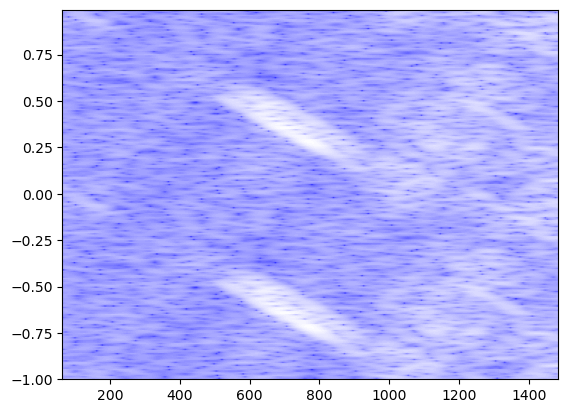

In [1681]:
plt.specgram(fft(new_sig), NFFT=256, noverlap=255, cmap='seismic', aspect='equal', vmin=-100, vmax=250, mode='psd')
plt.show()

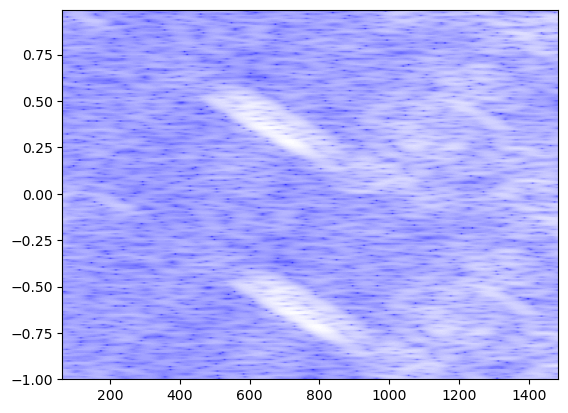

In [1682]:
plt.specgram(fft(deramped), NFFT=256, noverlap=255, cmap='seismic', aspect='equal', vmin=-100, vmax=250, mode='psd')
plt.show()

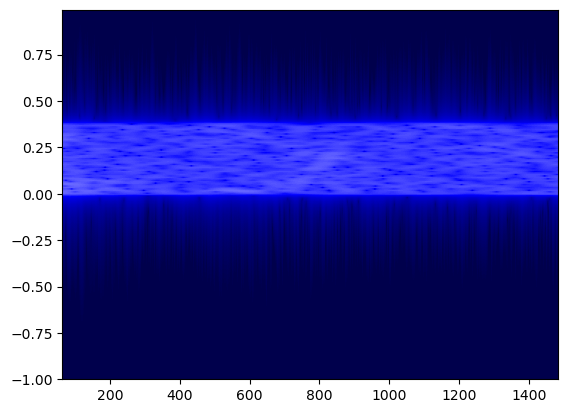

In [1683]:
plt.specgram(f, NFFT=256, noverlap=255, cmap='seismic', aspect='equal', vmin=-100, vmax=250)
plt.show()

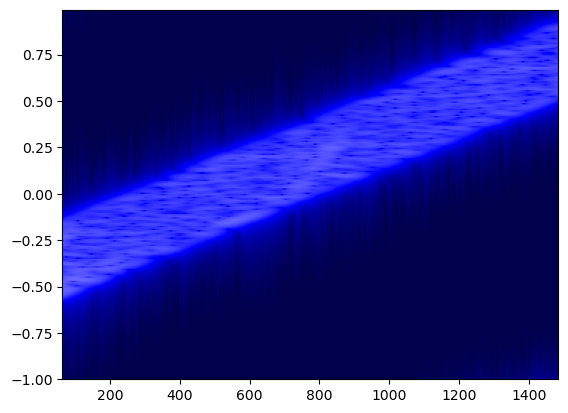

In [1684]:
plt.specgram(reramped, NFFT=256, noverlap=255, cmap='seismic', aspect='equal', vmin=-100, vmax=250, mode='psd')
plt.show()

In [1029]:
coefs_from_annot = [3.172399e+01, -7.151790e+04, 5.732541e+07][::-1]

In [847]:
def get_slant_range_times(header, num_times):
    # Same for all packets in a burst
    pulse_length = header["pulse_length"] * 1e-6
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = header["swst"] * 1e-6
    pri = header["pri"] * 1e-6
    rank = header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    return np.linspace(delay, delay+pulse_length, num_times)

In [846]:
rng_times = get_slant_range_times(header, num_rng)

In [1030]:
f_dc = np.polyval(coefs_from_annot, rng_times)

In [1031]:
f_dc

array([1455.4208806 , 1455.42235776, 1455.42383493, ..., 1491.33683276,
       1491.33832815, 1491.33982355])

In [1032]:
np.polyval(doppler_coefs, rng_times)

array([-138.40018415, -138.40018415, -138.40018415, ..., -138.40020109,
       -138.40020109, -138.40020109])

In [1387]:
def get_accc(signals, prf):
    xcors = (signals[1:, :] * signals[:-1, :].conj()).mean()
    return np.angle(xcors) * -prf / (2.0 * pi)

def get_accc_with_range_blocks(signals, prf, lag, range_block_size):
    num_az, num_rng = signals.shape
    num_range_blocks = num_rng // range_block_size
    accc = get_accc(signals, prf)
    amb_dcs = []
    for i in range(num_range_blocks):
        start_index = i * range_block_size
        end_index = start_index + range_block_size
        range_block = get_accc(signals[:, start_index:end_index], prf)
        amb_dcs.append(range_block)
    return np.asarray(amb_dcs)

def unwrap_doppler(doppler, prf):
    # From ISCE2
    frq2phs = 2 * np.pi / prf
    phs2frq = 1. / frq2phs
    return phs2frq * np.unwrap(frq2phs * doppler)

def unwrap_doppler_proto(doppler, min_rng_time, max_rng_time, range_block_size, prf):

    n = doppler.shape[0]
    Ts = (max_rng_time - min_rng_time) / n

    # center_time = (max_rng_time - min_rng_time) / 2
    
    fft_size = n
    # rng_times = np.linspace(-center_time/2, center_time/2, n)
    rng_times = np.linspace(min_rng_time, max_rng_time, n)
    print(Ts)
    print(n)
    print(fft_size)
    print(rng_times)

    u = np.exp(1j * 2 * pi * doppler / prf)
    u_fft = fftshift(fft(u, fft_size))

    v_index = np.argmax(np.abs(u_fft))

    freqs = fftshift(fftfreq(fft_size, Ts))
    v = freqs[v_index]

    a = v / Ts
    b = np.angle(u_fft[v_index]) / (2 * pi)

    print(f'freqs: {freqs}')
    print(f'u: {u}')
    print(f'u_fft: {u_fft}')
    print(f'np.abs(u_fft): {np.abs(u_fft)}')
    print(f'a: {a}')
    print(f'b: {b}')
    print(f'v: {v}')
    print(f'v_index: {v_index}')
    
    residual = np.angle(u * np.exp(-1j * (a * rng_times + b))) / (2 * pi)

    return (a * rng_times + b + residual) * prf
    
def get_doppler_coefs(signals, min_rng_time, max_rng_time, prf, lag=1, range_block_size=1000):
    """Signals param can be either range compressed data or the raw signals"""
    amb_dcs = get_accc_with_range_blocks(signals, prf, 1, range_block_size)
    print(amb_dcs)
    unwrapped = unwrap_doppler_proto(amb_dcs, min_rng_time, max_rng_time, range_block_size, prf)
    # unwrapped = unwrap_doppler(amb_dcs, prf)
    return unwrapped
    # unwrapped_doppler = unwrap_doppler(amb_dcs, prf)
    # return unwrapped_doppler
    # range_bins = np.arange(0, num_rng, range_block_size)[0:-1]
    # num_bins = num_rng // range_block_size
    # # num_bins += 1 if num_rng % range_block_size != 0 else 0
    # rng_times = np.linspace(min_rng_time, max_rng_time, num_bins)
    # print(rng_times.shape)
    # print(unwrapped_doppler.shape)
    # return np.polyfit(rng_times, unwrapped_doppler, 2)


start_time = azimuth_times[0]
az_times_s = np.asarray([(curr_time - start_time).total_seconds() for curr_time in azimuth_times[first_index:last_index+1]])
burst_len = az_times_s[-1] - az_times_s[0]
pri = header['pri'] * 1e-6
steering_angles = get_azimuth_steering_angles(burst_packets)
steering_rate = get_azimuth_steering_rate(steering_angles, pri)
ks = calculate_doppler_centroid_rate(np.linalg.norm(velocities[0]), steering_rate)
az_times_precon = np.linspace(0, burst_len, num_az)
dce_precon_sig = np.exp(1j * pi * ks * (az_times_precon - (burst_len / 2))**2)

In [1388]:
# test_coefs = get_doppler_coefs(precon, 0, 1, prf, 1, 1000)
# test_coefs
from scipy.fft import fftfreq
max_t = rng_times[-1] - rng_times[0]
unwrapped = get_doppler_coefs(precon, rng_times[0], rng_times[-1], prf, 1, 1000)

[-380.73050665 -389.58461265 -572.92617141 -414.90835705  650.72107456
  699.1085756   -88.43454023 -228.19062996 -404.41943676 -635.85021895
 -379.76730083 -560.98266328 -544.66657919  247.37124615 -539.3518813
  510.04640188  368.92698564   67.74368309 -440.67449529  208.22608296
   98.36312608 -184.65055772  636.8329955  -575.44036636]
2.5831637360568074e-06
24
24
[0.00564619 0.00564888 0.00565158 0.00565427 0.00565697 0.00565966
 0.00566236 0.00566505 0.00566775 0.00567044 0.00567314 0.00567584
 0.00567853 0.00568123 0.00568392 0.00568662 0.00568931 0.00569201
 0.0056947  0.0056974  0.00570009 0.00570279 0.00570549 0.00570818]
freqs: [-193561.09449076 -177431.0032832  -161300.91207563 -145170.82086807
 -129040.72966051 -112910.63845294  -96780.54724538  -80650.45603782
  -64520.36483025  -48390.27362269  -32260.18241513  -16130.09120756
       0.           16130.09120756   32260.18241513   48390.27362269
   64520.36483025   80650.45603782   96780.54724538  112910.63845294
  129040.

In [1386]:
unwrapped

array([-3.58255719e+11, -3.58426750e+11, -3.58597780e+11, -3.58768811e+11,
       -3.58939841e+11, -3.59110872e+11, -3.59281902e+11, -3.59452932e+11,
       -3.59623963e+11, -3.59794993e+11, -3.59966023e+11, -3.60137054e+11,
       -3.60308084e+11, -3.60479114e+11, -3.60650144e+11, -3.60821176e+11,
       -3.60992206e+11, -3.61163237e+11, -3.61334267e+11, -3.61505297e+11,
       -3.61676327e+11, -3.61847358e+11, -3.62018388e+11, -3.62189419e+11])

In [1378]:
coefs_from_annot_from_geom = [1.853132e+00, 4.717882e+02, -1.492730e+05][::-1]
coefs_from_annot_from_data = [8.213545e+00, 8.564302e+04, -8.959550e+07][::-1]
from_data = np.polyval(coefs_from_annot_from_data, rng_times)
from_geom = np.polyval(coefs_from_annot_from_geom, rng_times)
from_data, from_geom

(array([-2364.48170871, -2364.48408446, -2364.4864602 , ...,
        -2422.23585082, -2422.23825506, -2422.2406593 ]),
 array([-0.24179944, -0.24180255, -0.24180566, ..., -0.31762109,
        -0.31762425, -0.31762741]))

In [1069]:
rng_times

array([0.00564619, 0.00564619, 0.00564619, ..., 0.00570818, 0.00570818,
       0.00570818])

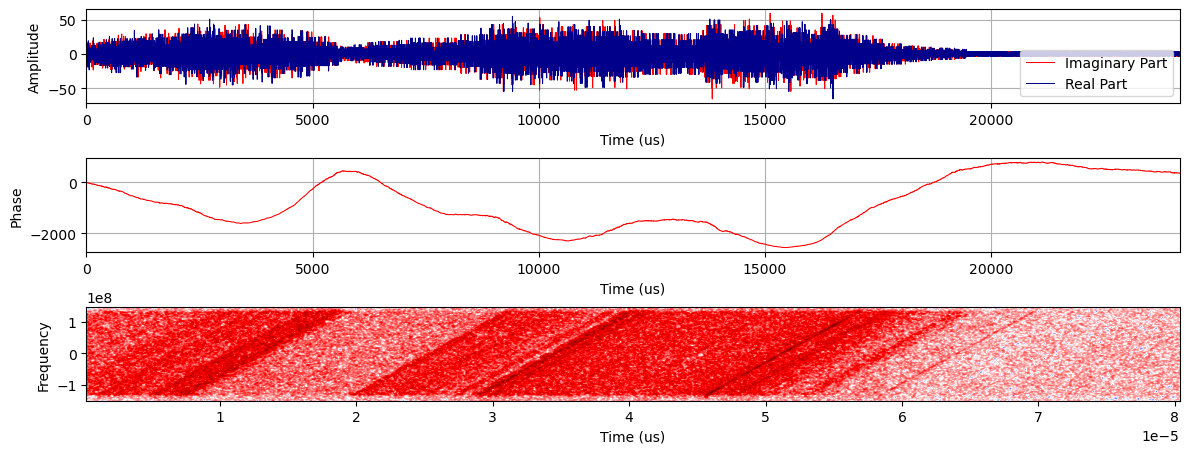

In [1017]:
plot_signal_components(signals[10, :])

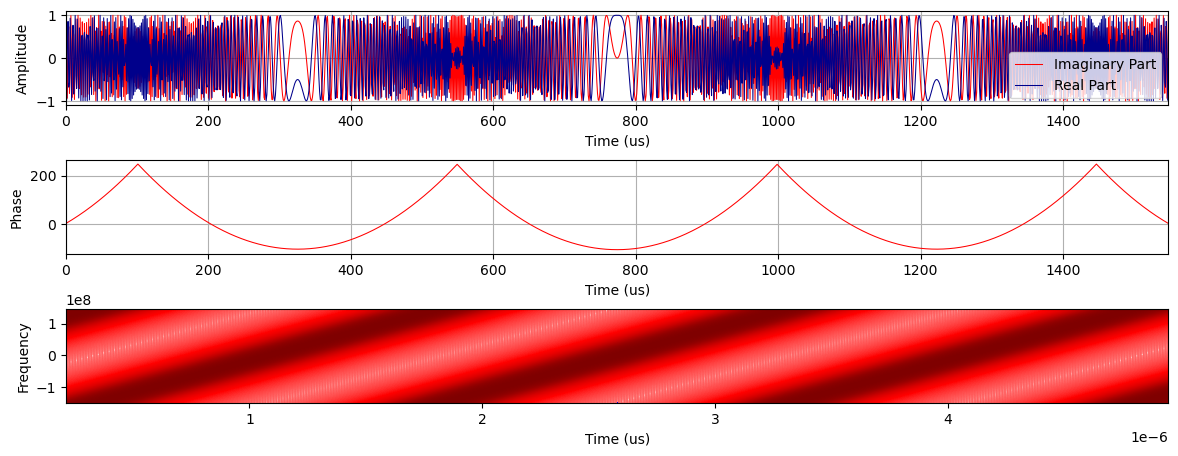

In [1016]:
plot_signal_components(dce_precon_sig)

In [1007]:
"""
Notes: 

Az times are of the form (-dt*num_lines_burst/2, dt*num_lines_burst/2)
Verified Doppler Centroid Rate Calc

Rng times for dop are like t_slant_range - t_0
so times - start_time

"""

'\nNotes: \n\nAz times are of the form (-dt*num_lines_burst/2, dt*num_lines_burst/2)\nVerified Doppler Centroid Rate Calc\n\n'

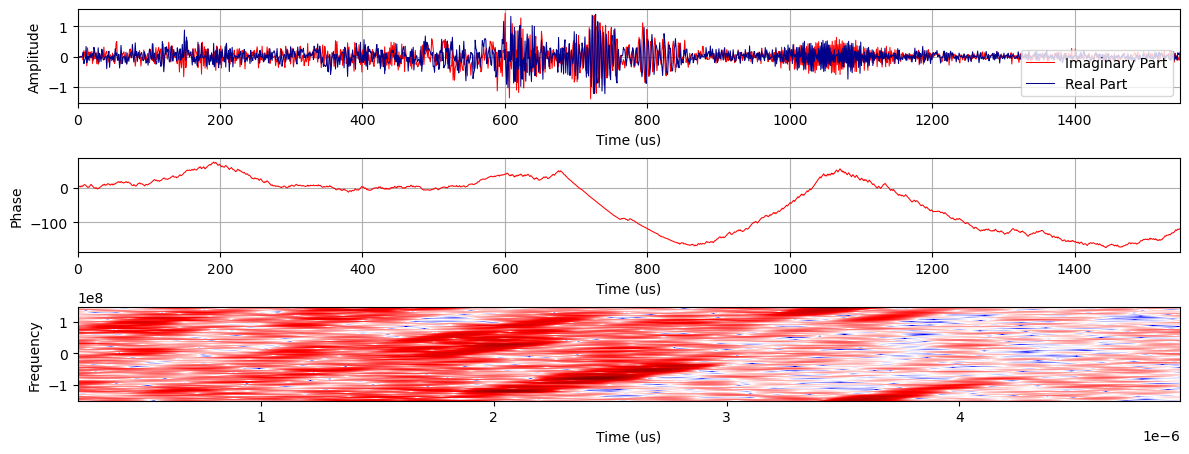

In [1020]:
precon = dce_precon_sig[:, np.newaxis] * range_compressed
plot_signal_components(precon[:, 0])

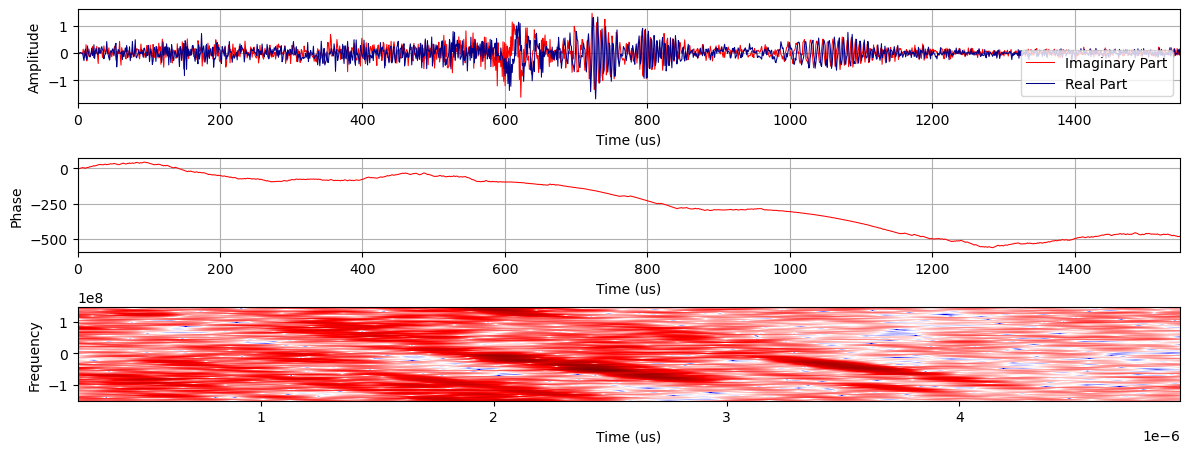

In [1021]:
plot_signal_components(range_compressed[:, 0])

In [1086]:
1.38186617e+08

138186617.0

In [1116]:
2.55896942e+11

255896942000.0

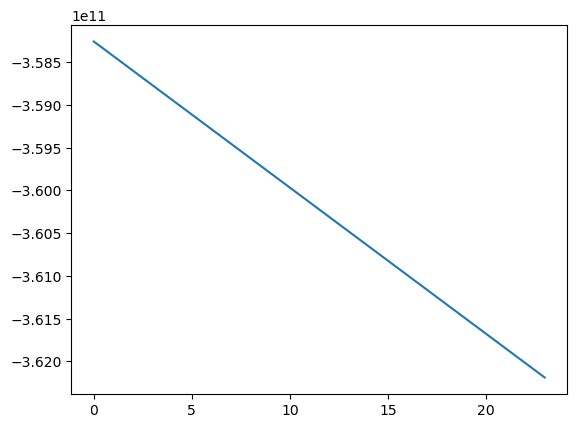

In [1321]:
plt.plot(unwrapped)

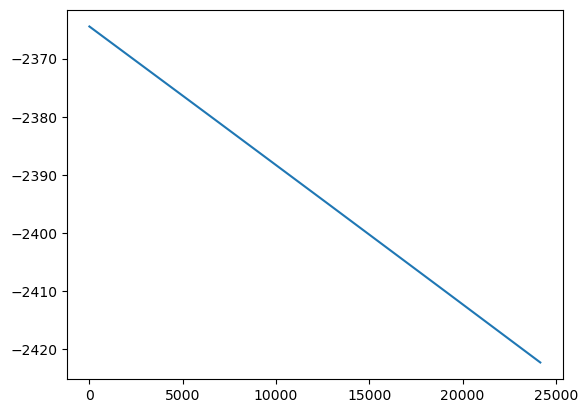

In [1322]:
plt.plot(from_data)

In [1249]:
np.diff(unwrapped) / np.max(np.abs(unwrapped))

array([-0.00047221, -0.00047221, -0.00047221, -0.00047221, -0.00047221,
       -0.00047221, -0.00047221, -0.00047221, -0.00047221, -0.00047221,
       -0.00047221, -0.00047221, -0.00047221, -0.00047221, -0.00047222,
       -0.00047221, -0.00047222, -0.00047221, -0.00047221, -0.00047221,
       -0.00047221, -0.00047221, -0.00047221])

In [1504]:
rng_times_offset = rng_times - rng_times[0]

In [1505]:
rng_times_offset

array([0.00000000e+00, 2.56531343e-09, 5.13062686e-09, ...,
       6.19907990e-05, 6.19933644e-05, 6.19959297e-05])

In [1510]:
t0 = 5.338558454430056e-03
t1 = 5.655518347528157e-03
c = [8.213545e+00, 8.564302e+04, -8.959550e+07]

In [1515]:
f_dc = c[0] + c[1]*rng_times_offset + c[2]*rng_times_offset**2

21.10000038146973